# TensorFlow Classification

### Getting Started

Dataset

`from sklearn.datasets import load_breast_cancer`

### Train Test Split and Scale

```
X = df.drop('target', axis=1).values
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30)

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit(X_test)
```

### Build the Model

With our output layer with regression we used 'relu' however with binary classification we use 'sigmoid' to get outputs that are between 0 and 1 

```
model = Sequential()

model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))


# Change the output activation layer to a sigmoid function
model.add(Dense(1, activation='sigmoid'))

# Change the loss functions to binary_crossentropy
model.compile(
  optimizer='adam',
  loss='binary_crossentropy'
)

history = model.fit(
  X_train,
  y_train,
  validation_data=(X_test, y_test),
  epochs = 25
)
```


### Evaluation

`pd.DataFrame(history.history).plot()`

### Predictions

With binary classification predictions, we don't get a 0 or 1 we get a value between 0 and 1.  We can use the 0.5 mark as an indication of whether it's really a 0 or 1


```
predictions = (model.predict(X_test) > 0.5) * 1

OR

predictions = np.argmax(model.predict(X_test))
```

```
confusion_matrix(y_test, predictions)
classification_report(y_test, predictions)
```

### TensorBoard

Create a Tensorboard Variable to use as a callback

```
tb = lambda desc: TensorBoard(
  log_dir = 'tf_logs/' \
  + desc \
  + '_' \
  + datetime.datetime.now().strftime('%Y%m%d_%H:%M:%S'))
```

Upload Logs to TensorBoard - Do not upload sensitive data!

```
!tensorboard dev upload --logdir ./tf_logs \
--name 'My First TensorBoard' \
--description 'Classification with some models' \
--one_shot
```

List TensorBoard's that have been created

`!tensorboard dev list`

Delete TensorBoards

`!tensorboard dev delete --experiment EXPERIMENT_ID`

In [71]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler

from sklearn.datasets import load_breast_cancer

### Load data and create DataFrame

In [61]:
data = load_breast_cancer()

In [62]:
df = pd.DataFrame(data.data, columns=data.feature_names)

In [63]:
df['target'] = data.target

In [64]:
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [65]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


### Train Test Split and Scale

In [66]:
X = df.drop('target', axis=1).values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [67]:
# Scale the data

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [70]:
len(X_train)

398

### TensorBoard Configuration

In [72]:
tb = lambda description: TensorBoard(log_dir='tf_logs/' \
                 + description \
                 + '_' \
                 + datetime.datetime.now().strftime('%Y%m%d_%H:%M:%S'))



### Build Model

3 Hidden Layers
- Activation **relu**
- 128 Units per layer

Compiler
- Optimizer: Adam
- Loss: binary_crossentropy
- Metric: accuracy

Callbacks
- TensorBoard
- EarlyStopping

In [73]:
model_1 = Sequential()

model_1.add(Dense(128, activation='relu', name='DenseLayer1'))
model_1.add(Dense(128, activation='relu', name='DenseLayer2'))
model_1.add(Dense(128, activation='relu', name='DenseLayer3'))

# classification output layer
# The activation must be sigmoid
model_1.add(Dense(1, activation='sigmoid', name='OutputLayer'))


# Compilation
model_1.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

es = EarlyStopping(monitor='accuracy', mode='max', patience=10, verbose=1)

history_1 = model_1.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=250,
    callbacks=[es, tb('model_1')]
)

Epoch 1/250
13/13 [==============================] - 1s 29ms/step - loss: 0.6371 - accuracy: 0.6457 - val_loss: 0.5770 - val_accuracy: 0.8129
Epoch 2/250
13/13 [==============================] - 0s 10ms/step - loss: 0.4974 - accuracy: 0.8417 - val_loss: 0.4100 - val_accuracy: 0.9181
Epoch 3/250
13/13 [==============================] - 0s 10ms/step - loss: 0.3516 - accuracy: 0.8492 - val_loss: 0.3113 - val_accuracy: 0.8772
Epoch 4/250
13/13 [==============================] - 0s 10ms/step - loss: 0.2826 - accuracy: 0.8744 - val_loss: 0.2049 - val_accuracy: 0.9298
Epoch 5/250
13/13 [==============================] - 0s 10ms/step - loss: 0.2088 - accuracy: 0.9196 - val_loss: 0.1598 - val_accuracy: 0.9532
Epoch 6/250
13/13 [==============================] - 0s 12ms/step - loss: 0.1801 - accuracy: 0.9397 - val_loss: 0.1520 - val_accuracy: 0.9532
Epoch 7/250
13/13 [==============================] - 0s 12ms/step - loss: 0.1539 - accuracy: 0.9322 - val_loss: 0.1045 - val_accuracy: 0.9649
Epoch 

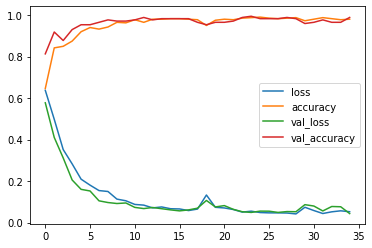

In [74]:
pd.DataFrame(history_1.history).plot()

### Add Dropout - Prevent Overfitting

If we have a problem with overtraining our data we can use Dropouts to slow down our model's learning on the training data

the accuracy on the training data is higher than the val_accuracy
the val_accuracy is lower than the accuracy



In [76]:
model_2 = Sequential()


model_2.add(Dense(128, activation='relu', name='DenseLayer1'))
model_2.add(Dropout(0.5, name='DroputLayer1'))

# Droput will randomly drop 50% (based on above) before sending to this layer
# Layer 2 receives only 64 inputs, all others inputs will be 0
# Randomly chosen every epoch
model_2.add(Dense(128, activation='relu', name='DenseLayer2'))
model_2.add(Dropout(0.5, name='DroputLayer2'))


model_2.add(Dense(128, activation='relu', name='DenseLayer3'))
model_2.add(Dropout(0.5, name='DroputLayer3'))

# classification output layer
# The activation must be sigmoid
model_2.add(Dense(1, activation='sigmoid', name='OutputLayer'))


# Compilation
model_2.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

es = EarlyStopping(monitor='accuracy', mode='max', patience=10, verbose=1)

history_2 = model_2.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=250,
    callbacks=[es, tb('model_2_added_dropouts')]
)

Epoch 1/250
13/13 [==============================] - 1s 20ms/step - loss: 0.6878 - accuracy: 0.5553 - val_loss: 0.6553 - val_accuracy: 0.9123
Epoch 2/250
13/13 [==============================] - 0s 7ms/step - loss: 0.6423 - accuracy: 0.7010 - val_loss: 0.6021 - val_accuracy: 0.9181
Epoch 3/250
13/13 [==============================] - 0s 6ms/step - loss: 0.5827 - accuracy: 0.7965 - val_loss: 0.4974 - val_accuracy: 0.9181
Epoch 4/250
13/13 [==============================] - 0s 6ms/step - loss: 0.5127 - accuracy: 0.8065 - val_loss: 0.3819 - val_accuracy: 0.9357
Epoch 5/250
13/13 [==============================] - 0s 5ms/step - loss: 0.4034 - accuracy: 0.8241 - val_loss: 0.2791 - val_accuracy: 0.9123
Epoch 6/250
13/13 [==============================] - 0s 7ms/step - loss: 0.3384 - accuracy: 0.8719 - val_loss: 0.2104 - val_accuracy: 0.9532
Epoch 7/250
13/13 [==============================] - 0s 6ms/step - loss: 0.3150 - accuracy: 0.8844 - val_loss: 0.1689 - val_accuracy: 0.9474
Epoch 8/250


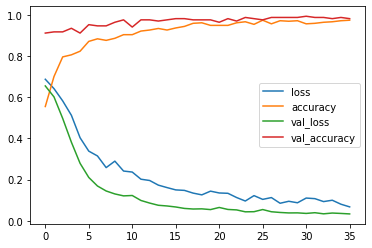

In [77]:
pd.DataFrame(history_2.history).plot()

### Reduce the Units - Reduce Units

 Another way to solve overfitting is to reduce the number of units per layer

In [78]:
model_3 = Sequential()


model_3.add(Dense(32, activation='relu', name='DenseLayer1'))
# model_3.add(Dropout(0.5, name='DroputLayer1'))

# Droput will randomly drop 50% (based on above) before sending to this layer
# Layer 2 receives only 64 inputs, all others inputs will be 0
# Randomly chosen every epoch
model_3.add(Dense(32, activation='relu', name='DenseLayer2'))
# model_3.add(Dropout(0.5, name='DroputLayer2'))


model_3.add(Dense(32, activation='relu', name='DenseLayer3'))
# model_3.add(Dropout(0.5, name='DroputLayer3'))

# classification output layer
# The activation must be sigmoid
model_3.add(Dense(1, activation='sigmoid', name='OutputLayer'))


# Compilation
model_3.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

es = EarlyStopping(monitor='accuracy', mode='max', patience=10, verbose=1)

history_3 = model_3.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=250,
    callbacks=[es, tb('model_3_reduced_inputs')]
)

Epoch 1/250
13/13 [==============================] - 1s 19ms/step - loss: 0.6874 - accuracy: 0.6106 - val_loss: 0.6744 - val_accuracy: 0.8129
Epoch 2/250
13/13 [==============================] - 0s 6ms/step - loss: 0.6595 - accuracy: 0.8518 - val_loss: 0.6381 - val_accuracy: 0.9064
Epoch 3/250
13/13 [==============================] - 0s 7ms/step - loss: 0.6153 - accuracy: 0.8794 - val_loss: 0.5760 - val_accuracy: 0.9123
Epoch 4/250
13/13 [==============================] - 0s 6ms/step - loss: 0.5444 - accuracy: 0.8844 - val_loss: 0.4939 - val_accuracy: 0.9298
Epoch 5/250
13/13 [==============================] - 0s 6ms/step - loss: 0.4551 - accuracy: 0.8995 - val_loss: 0.3912 - val_accuracy: 0.9415
Epoch 6/250
13/13 [==============================] - 0s 7ms/step - loss: 0.3591 - accuracy: 0.9020 - val_loss: 0.2920 - val_accuracy: 0.9415
Epoch 7/250
13/13 [==============================] - 0s 6ms/step - loss: 0.2882 - accuracy: 0.8970 - val_loss: 0.2196 - val_accuracy: 0.9474
Epoch 8/250


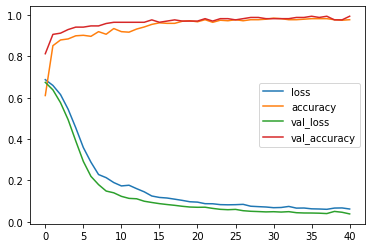

In [79]:
pd.DataFrame(history_3.history).plot()

### Predictions

In [80]:
model_1.evaluate(X_train, y_train)

13/13 [==============================] - 0s 11ms/step - loss: 0.0450 - accuracy: 0.9824


[0.04497213661670685, 0.9824120402336121]

In [81]:
model_2.evaluate(X_train, y_train)

13/13 [==============================] - 0s 3ms/step - loss: 0.0508 - accuracy: 0.9799


[0.050762683153152466, 0.979899525642395]

In [82]:
model_3.evaluate(X_train, y_train)

13/13 [==============================] - 0s 6ms/step - loss: 0.0565 - accuracy: 0.9849


[0.056503649801015854, 0.9849246144294739]

In [86]:
prediction_3 = (model_3.predict(X_test) > 0.5) * 1

In [87]:
prediction_3

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
    

In [85]:
y_test

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1])

In [89]:
confusion_matrix(y_test, prediction_3)

array([[ 51,   1],
       [  0, 119]])

In [91]:
print(classification_report(y_test, prediction_3))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        52
           1       0.99      1.00      1.00       119

    accuracy                           0.99       171
   macro avg       1.00      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171



### Tensorboard

Upload Data to Google TensorBoard
- Requires auth with Google account
- Will be public for everyone to see
- Do not upload private or sensitive data

In [93]:
!tensorboard dev upload --logdir ./tf_logs \
--name 'My First TensorBoard' \
--description 'Classification with some models' \
--one_shot

2022-07-08 09:01:05.604793: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/BzBpqW9uRQeN4OehJ7NYkA/

[2022-07-08T09:01:05] Started scanning logdir.
[2022-07-08T09:01:09] Total uploaded: 954 scalars, 0 tensors, 4 binary objects (209.3 kB)
[2022-07-08T09:01:09] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/BzBpqW9uRQeN4OehJ7NYkA/


In [94]:
!tensorboard dev list

2022-07-08 09:06:09.303488: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
https://tensorboard.dev/experiment/BzBpqW9uRQeN4OehJ7NYkA/
	Name                 My First TensorBoard
	Description          Classification with some models
	Id                   BzBpqW9uRQeN4OehJ7NYkA
	Created              2022-07-08 09:01:05 (5 minutes ago)
	Updated              2022-07-08 09:01:09 (5 minutes ago)
	Runs                 8
	Tags                 5
	Scalars              954
	Tensor bytes         0
	Binary object bytes  215014
Total: 1 experiment(s)


In [95]:
!tensorboard dev delete --experiment BzBpqW9uRQeN4OehJ7NYkA

2022-07-08 09:06:51.193987: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Deleted experiment BzBpqW9uRQeN4OehJ7NYkA.


In [96]:
!tensorboard dev list

2022-07-08 09:07:00.015417: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No experiments. Use `tensorboard dev upload` to get started.
